In [78]:
import pandas as pd
import requests
import re
import emoji
import string
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.utils import parallel_backend
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

In [100]:
# Step 1: Load the data from a published Google Sheet CSV
google_sheet_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTPvyKH65pZuIYA2hb-ppL91n0Af_LBtoo7FyScMGfoN5fnD9MEX_6Udpo0E5gHH1ZLqjGkA301J1zo/pub?output=csv"
response = requests.get(google_sheet_url)
open('tweets.csv', 'wb').write(response.content)  # Save it locally as 'tweets.csv'

# Step 2: Read the dataset
df = pd.read_csv('tweets.csv')

# Step 3: Clean the text data (remove hashtags, name tags, and line breaks)
def clean_text(text):
    if not isinstance(text, str):  # Check if the input is a string
        return ''
    text = re.sub(r'@\w+', '', text)  # Remove @name mentions (name tags)
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = text.replace('\n', ' ').replace('\r', '')  # Remove line breaks
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    return text.strip()


# Apply the cleaning function to each entry in the 'text' column
df['Tweet'] = df['Tweet'].apply(clean_text)
df = df[df['Tweet'] != '']
df.dropna(subset=['code-switched'], inplace=True)
df.dropna(subset=['Hate'], inplace=True)
df

,Tweet,Keyword,code-switched,Hate
0,Ladies Night Happening tomorrow Door open ...,#Edo2024,0,Neutral
1,They are crying that I don't talk. My silence...,#Edo2024,0,Neutral
2,"After 25yrs of PDP and APC for Edo state, my p...",#Edo2024,1,Offensive
3,The people can trust Labour Party. Ondo and Ab...,#Edo2024,0,Neutral
4,I'll keep the grudges even after the elections...,#Edo2024,0,Hate
...,...,...,...,...
12685,Nawa o,nawa o,1,Neutral
12686,Nawa o. Food cost an Arm and leg. I just d...,nawa o,1,Neutral
12687,Nawa o,nawa o,1,Neutral
12688,Nawa for you o,nawa o,1,Neutral


In [101]:
df['Tweet'] = df['Tweet'].apply(lambda x: x.lower() if isinstance(x, str) else x)
df

,Tweet,Keyword,code-switched,Hate
0,ladies night happening tomorrow door open ...,#Edo2024,0,Neutral
1,they are crying that i don't talk. my silence...,#Edo2024,0,Neutral
2,"after 25yrs of pdp and apc for edo state, my p...",#Edo2024,1,Offensive
3,the people can trust labour party. ondo and ab...,#Edo2024,0,Neutral
4,i'll keep the grudges even after the elections...,#Edo2024,0,Hate
...,...,...,...,...
12685,nawa o,nawa o,1,Neutral
12686,nawa o. food cost an arm and leg. i just d...,nawa o,1,Neutral
12687,nawa o,nawa o,1,Neutral
12688,nawa for you o,nawa o,1,Neutral


In [102]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","dont": "do not", "i’d": "I would","doesn’t": "does not"}

In [103]:
# contractions_re = re.compile('({})'.format('|'.join(contractions_dict.keys())))
contractions_re = re.compile('({})'.format('|'.join(re.escape(key) for key in contractions_dict.keys())))

contractions_re

re.compile(r"(ain't|'s|aren't|can't|can't've|'cause|could've|couldn't|couldn't've|didn't|doesn't|don't|hadn't|hadn't've|hasn't|haven't|he'd|he'd've|he'll|he'll've|how'd|how'd'y|how'll|I'd|I'd've|I'll|I'll've|I'm|I've|isn't|it'd|it'd've|it'll|it'll've|let's|ma'am|mayn't|might've|mightn't|mightn't've|must've|mustn't|mustn't've|needn't|needn't've|o'clock|oughtn't|oughtn't've|shan't|sha'n't|shan't've|she'd|she'd've|she'll|she'll've|should've|shouldn't|shouldn't've|so've|that'd|that'd've|there'd|there'd've|they'd|they'd've|they'll|they'll've|they're|they've|to've|wasn't|we'd|we'd've|we'll|we'll've|we're|we've|weren't|what'll|what'll've|what're|what've|when've|where'd|where've|who'll|who'll've|who've|why've|will've|won't|won't've|would've|wouldn't|wouldn't've|y'all|y'all'd|y'all'd've|y'all're|y'all've|you'd|you'd've|you'll|you'll've|you're|you've|dont|i’d|doesn’t)",
           re.UNICODE)

In [104]:
# Function for expanding contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [105]:
# Apply the function to the 'cleaned' column
df['Tweet'] = df['Tweet'].apply(lambda x: expand_contractions(x) if isinstance(x, str) else x) #word contraction removal
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('[{}]'.format(re.escape(string.punctuation)), ' ',x) if isinstance(x, str) else x) # removal of punctuations
df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('\w*\d\w*','',x) if isinstance(x, str) else x) #removal of digit characters
df_ = df
df_

,Tweet,Keyword,code-switched,Hate
0,ladies night happening tomorrow door open ...,#Edo2024,0,Neutral
1,they are crying that i do not talk my silenc...,#Edo2024,0,Neutral
2,after of pdp and apc for edo state my people...,#Edo2024,1,Offensive
3,the people can trust labour party ondo and ab...,#Edo2024,0,Neutral
4,i ll keep the grudges even after the elections...,#Edo2024,0,Hate
...,...,...,...,...
12685,nawa o,nawa o,1,Neutral
12686,nawa o food cost an arm and leg i just d...,nawa o,1,Neutral
12687,nawa o,nawa o,1,Neutral
12688,nawa for you o,nawa o,1,Neutral


In [106]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [107]:
df_['Tweet'] = df_['Tweet'].apply(lambda x: " ".join(token.lemma_ for token in nlp(x) if not token.is_stop) if isinstance(x, str) else x)

In [108]:
review_grouped = df_[['Keyword','Tweet']].groupby('Keyword').sum()

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(review_grouped['Tweet'])
df_ = pd.DataFrame(data.toarray(), columns=cv.get_feature_names_out())
df_.index = review_grouped.index
df_.head(10)

,aaa,aac,aacstop,aanzi,aanzishebi,aare,aaron,ab,aba,abacha,...,𝙎𝙩𝙖𝙩𝙚asue,𝙒𝙝𝙮,𝙗𝙚𝙘𝙤𝙢𝙚,𝙙𝙤,𝙜𝙤𝙫𝙚𝙧𝙣𝙤𝙧,𝙤𝙛,𝙩𝙝𝙚,𝙩𝙤,𝙬𝙖𝙣𝙩,𝙮𝙤𝙪
Keyword,,,,,,,,,,,,,,,,,,,,,
#APC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#EDonDo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#Edo guber,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#Edo2024,0,1,1,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
#EdoDecides2024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#EdoPeopleBeforePolitics,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#EdoPeopleMustToMatter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#EdoWillBeOK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#Obidients,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
df_dtm = df_.transpose()
df_dtm

Keyword,#APC,#EDonDo,#Edo guber,#Edo2024,#EdoDecides2024,#EdoPeopleBeforePolitics,#EdoPeopleMustToMatter,#EdoWillBeOK,#Obidients,#RevolutionNow,...,na wa o,nawa o,ode osi,petrol,petrol scarcity,pump price,shege,wahala,werey,weyrey
aaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aac,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aacstop,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aanzi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aanzishebi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
𝙤𝙛,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝙩𝙝𝙚,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝙩𝙤,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝙬𝙖𝙣𝙩,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
new = df[['Keyword', 'Tweet','code-switched','Hate' ]]
new = new[new['Hate'] != 'Neutral ']
new = new[new['code-switched'] != 'p']
new


,Keyword,Tweet,code-switched,Hate
0,#Edo2024,lady night happen tomorrow door open ...,0,Neutral
1,#Edo2024,cry talk silence weapon community builde...,0,Neutral
2,#Edo2024,pdp apc edo state people market,1,Offensive
3,#Edo2024,people trust labour party ondo abia good exa...,0,Neutral
4,#Edo2024,ll grudge election near fake love,0,Hate
...,...,...,...,...
12685,nawa o,nawa o,1,Neutral
12686,nawa o,nawa o food cost arm leg dey scream ma...,1,Neutral
12687,nawa o,nawa o,1,Neutral
12688,nawa o,nawa o,1,Neutral


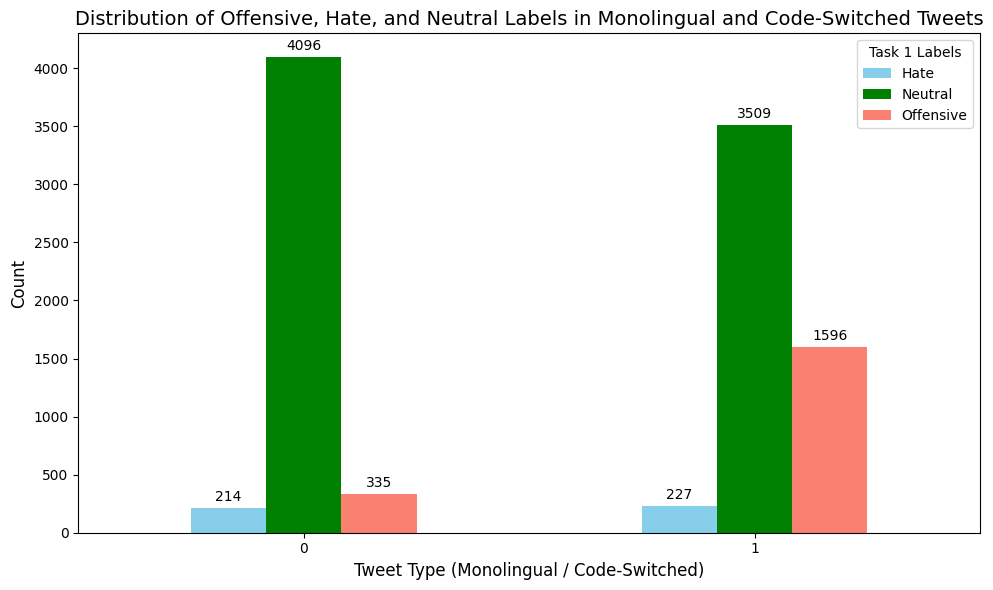

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a new DataFrame with the counts for each label in Task 1 (Offensive, Hate, Neutral)
# and group them by Task 2 (Monolingual, Code-switched)

# Assuming y_train_task1, y_train_task2 represent the training labels for task 1 and task 2
# data = pd.DataFrame({'Task1_Label': new['Hate'], 'Task2_Label':new['code-switched'] })

# 1. Create a grouped DataFrame to count occurrences of each label in monolingual vs. code-switched tweets
grouped_counts = df.groupby([new['code-switched'],  new['Hate']]).size().unstack().fillna(0)

# Get the counts of offensive, hate, neutral in both monolingual and code-switched tweets
label_counts = data.groupby(['Task2_Label', 'Task1_Label']).size().unstack(fill_value=0)

# 2. Plot the bar chart
ax = grouped_counts.plot(kind='bar', stacked=False, figsize=(10, 6), color=['skyblue', 'green', 'salmon'])

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=3)

# 4. Customize the chart
plt.title('Distribution of Offensive, Hate, and Neutral Labels in Monolingual and Code-Switched Tweets', fontsize=14)
plt.xlabel('Tweet Type (Monolingual / Code-Switched)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Task 1 Labels', loc='upper right')
plt.tight_layout()

# 5. Show the plot
plt.show()


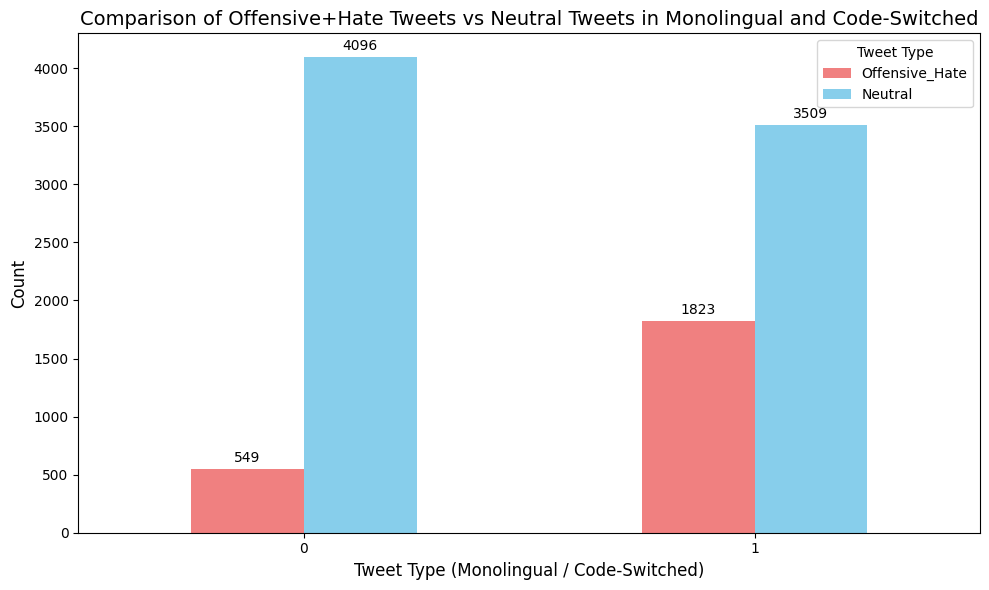

In [139]:
import matplotlib.pyplot as plt

# 1. Group data by 'label_task2' (Monolingual, Code-Switched) and 'label_task1' (Offensive, Hate, Neutral)
grouped_labels = new.groupby(['code-switched', 'Hate']).size().unstack(fill_value=0)

# 2. Calculate the sum of offensive and hate tweets
grouped_labels['Offensive_Hate'] = grouped_labels['Offensive'] + grouped_labels['Hate']

# 3. Create a new DataFrame to compare 'Offensive_Hate' vs 'Neutral'
compare_df = grouped_labels[['Offensive_Hate', 'Neutral']]

# 4. Plot the bar chart
ax = compare_df.plot(kind='bar', figsize=(10, 6), color=['lightcoral', 'skyblue'])

# 5. Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, padding=3)

# 6. Customize the chart
plt.title('Comparison of Offensive+Hate Tweets vs Neutral Tweets in Monolingual and Code-Switched', fontsize=14)
plt.xlabel('Tweet Type (Monolingual / Code-Switched)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Tweet Type', loc='upper right')
plt.tight_layout()

# 7. Show the plot
plt.show()


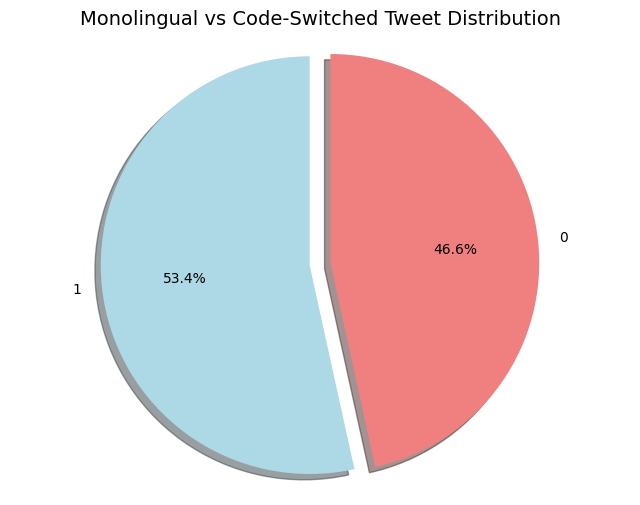

In [135]:
# 1. Calculate the distribution of Monolingual and Code-Switched tweets
monolingual_code_switched_counts = new['code-switched'].value_counts()

# 2. Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(monolingual_code_switched_counts, labels=monolingual_code_switched_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=['lightblue', 'lightcoral'], explode=(0.05, 0.05), shadow=True)

# 3. Customize the chart
plt.title('Monolingual vs Code-Switched Tweet Distribution', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle

# 4. Show the plot
plt.show()


In [112]:
# Step 4: Prepare the two label sets (offensive/hate/neutral) and (monolingual/code-switched)
X = new['Tweet']  # Text data
y_task1 = new['code-switched']  # Labels for task 1 (monolingual, code-switched)
y_task2 = new['Hate']  # Labels for task 2 (offensive, hate, neutral)

# 3. Split data into train and test sets (stratified)
X_train, X_test, y_train_task1, y_test_task1, y_train_task2, y_test_task2 = train_test_split(
    X, y_task1, y_task2, test_size=0.2, random_state=42, stratify=y_task1
)

# 5. Initialize other classifiers (Naive Bayes, SVM, Logistic Regression)
nb_model_task1 = MultinomialNB()
svm_model_task1 = LinearSVC()

nb_model_task2 = MultinomialNB()
svm_model_task2 = LinearSVC()

logistic_meta_task1 = LogisticRegression()
logistic_meta_task2 = LogisticRegression()

# 6. Apply SMOTE to oversample minority classes (with k_neighbors=1)
smote = SMOTE(k_neighbors=5)

In [113]:
# Check the class distribution
print(f"Task 1 class distribution before SMOTE: {Counter(y_train_task1)}")
print(f"Task 2 class distribution before SMOTE: {Counter(y_train_task2)}")

Task 1 class distribution before SMOTE: Counter({'1': 4265, '0': 3716})
Task 2 class distribution before SMOTE: Counter({'Neutral': 6075, 'Offensive': 1556, 'Hate': 350})


In [114]:
# 7. Define the StackingClassifier with reduced cv and use LinearSVC for faster training
stacking_clf_task1 = StackingClassifier(
    estimators=[
        ('nb_task1', nb_model_task1),
        ('svm_task1', svm_model_task1),
    ],
    final_estimator=logistic_meta_task1,
    cv=5  # Reduce to 5-fold cross-validation
)

stacking_clf_task2 = StackingClassifier(
    estimators=[
        ('nb_task2', nb_model_task2),
        ('svm_task2', svm_model_task2),
    ],
    final_estimator=logistic_meta_task2,
    cv=5
)

# 8. Set up pipelines with SMOTE, TF-IDF, and the stacking model
pipeline_task1 = ImbPipeline(steps=[
    ('tfidf', tfidf),
    ('smote', smote),
    ('stacking', stacking_clf_task1)
])

pipeline_task2 = ImbPipeline(steps=[
    ('tfidf', tfidf),
    ('smote', smote),
    ('stacking', stacking_clf_task2)
])

# 9. Randomized search for hyperparameter tuning
param_dist_task1 = {
    'stacking__svm_task1__C': [0.1, 1, 10],
    'stacking__svm_task1__penalty': ['l2'],
    'stacking__svm_task1__loss': ['hinge', 'squared_hinge'],
    'stacking__nb_task1__alpha': [0.5, 1, 1.5]
}

param_dist_task2 = {
    'stacking__svm_task2__C': [0.1, 1, 10],
    'stacking__svm_task2__penalty': ['l2'],
    'stacking__svm_task2__loss': ['hinge', 'squared_hinge'],
    'stacking__nb_task2__alpha': [0.5, 1, 1.5]
}

random_search_task1 = RandomizedSearchCV(
    pipeline_task1, param_dist_task1, cv=3, n_iter=10, scoring='accuracy', n_jobs=-1
)
random_search_task2 = RandomizedSearchCV(
    pipeline_task2, param_dist_task2, cv=3, n_iter=10, scoring='accuracy', n_jobs=-1
)

# 10. Train models with RandomizedSearchCV and parallel processing
with parallel_backend('threading'):
    random_search_task1.fit(X_train, y_train_task1)
    random_search_task2.fit(X_train, y_train_task2)

# 11. Evaluate the best models on the test sets
y_pred_test_task1 = random_search_task1.best_estimator_.predict(X_test)
y_pred_test_task2 = random_search_task2.best_estimator_.predict(X_test)

accuracy_test_task1 = accuracy_score(y_test_task1, y_pred_test_task1)
report_test_task1 = classification_report(y_test_task1, y_pred_test_task1)

accuracy_test_task2 = accuracy_score(y_test_task2, y_pred_test_task2)
report_test_task2 = classification_report(y_test_task2, y_pred_test_task2)

# 12. Output the results
print(f"Test Accuracy Task 1: {accuracy_test_task1}")
print("Classification Report Task 1:")
print(report_test_task1)

print(f"Test Accuracy Task 2: {accuracy_test_task2}")
print("Classification Report Task 2:")
print(report_test_task2)

# Save the best models
joblib.dump(random_search_task1.best_estimator_, 'best_model_task1.pkl')
joblib.dump(random_search_task2.best_estimator_, 'best_model_task2.pkl')

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value

Test Accuracy Task 1: 0.9123246492985972
Classification Report Task 1:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       929
           1       0.95      0.88      0.91      1067

    accuracy                           0.91      1996
   macro avg       0.91      0.91      0.91      1996
weighted avg       0.92      0.91      0.91      1996

Test Accuracy Task 2: 0.7900801603206413
Classification Report Task 2:
              precision    recall  f1-score   support

        Hate       0.19      0.29      0.23        91
     Neutral       0.89      0.85      0.87      1530
   Offensive       0.62      0.67      0.64       375

    accuracy                           0.79      1996
   macro avg       0.57      0.60      0.58      1996
weighted avg       0.81      0.79      0.80      1996



['best_model_task2.pkl']

Test Accuracy Task 1: 0.9123246492985972
Classification Report Task 1:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       929
           1       0.95      0.88      0.91      1067

    accuracy                           0.91      1996
   macro avg       0.91      0.91      0.91      1996
weighted avg       0.92      0.91      0.91      1996

Test Accuracy Task 2: 0.7900801603206413
Classification Report Task 2:
              precision    recall  f1-score   support

        Hate       0.19      0.29      0.23        91
     Neutral       0.89      0.85      0.87      1530
   Offensive       0.62      0.67      0.64       375

    accuracy                           0.79      1996
   macro avg       0.57      0.60      0.58      1996
weighted avg       0.81      0.79      0.80      1996



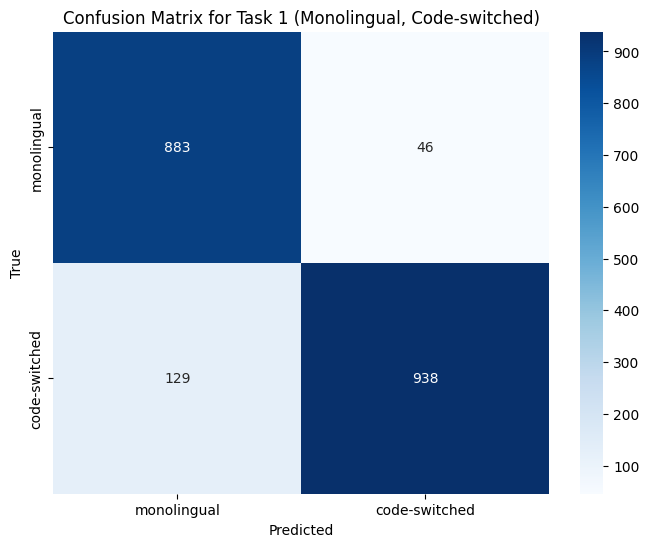

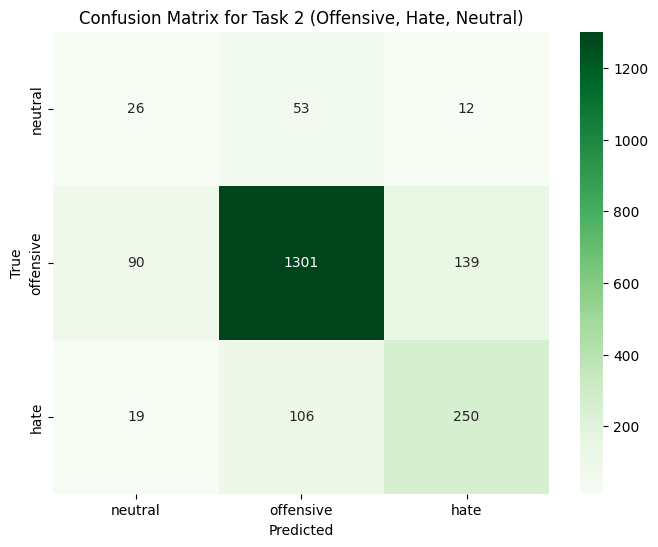

In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 11. Evaluate the best models on the test sets
y_pred_test_task1 = random_search_task1.best_estimator_.predict(X_test)
y_pred_test_task2 = random_search_task2.best_estimator_.predict(X_test)

accuracy_test_task1 = accuracy_score(y_test_task1, y_pred_test_task1)
report_test_task1 = classification_report(y_test_task1, y_pred_test_task1)

accuracy_test_task2 = accuracy_score(y_test_task2, y_pred_test_task2)
report_test_task2 = classification_report(y_test_task2, y_pred_test_task2)

# 12. Output the results
print(f"Test Accuracy Task 1: {accuracy_test_task1}")
print("Classification Report Task 1:")
print(report_test_task1)

print(f"Test Accuracy Task 2: {accuracy_test_task2}")
print("Classification Report Task 2:")
print(report_test_task2)

# 13. Confusion Matrix for Task 1
cm_task1 = confusion_matrix(y_test_task1, y_pred_test_task1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_task1, annot=True, fmt='d', cmap='Blues', xticklabels=['monolingual', 'code-switched'], yticklabels=['monolingual', 'code-switched'])
plt.title('Confusion Matrix for Task 1 (Monolingual, Code-switched)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 14. Confusion Matrix for Task 2
cm_task2 = confusion_matrix(y_test_task2, y_pred_test_task2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_task2, annot=True, fmt='d', cmap='Greens', xticklabels=['neutral', 'offensive', 'hate'], yticklabels=['neutral', 'offensive', 'hate'])
plt.title('Confusion Matrix for Task 2 (Offensive, Hate, Neutral)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
